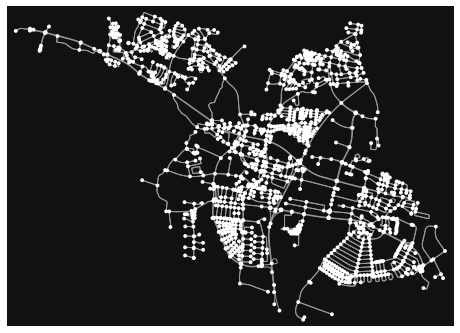

/opt/conda/lib/python3.7/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


[174, 45, 176, 177, 521, 527, 41, 39, 51, 52, 19, 50, 443, 666, 372, 371, 369, 367, 368, 453, 456, 459]
{'Ballerup Boulevard', 'Ågerupvej', 'Tjørnevænget', 'Tangevej', 'Harrestrupvej', 'Vestbuen'}


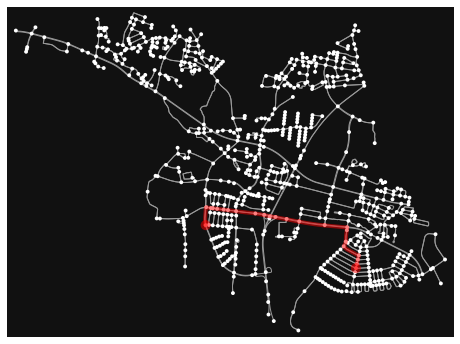

/opt/conda/lib/python3.7/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/opt/conda/lib/python3.7/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


<AxesSubplot:>

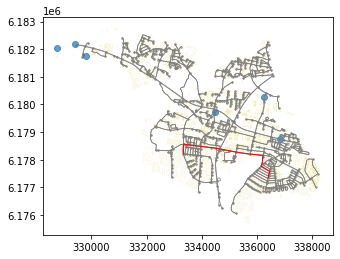

In [2]:
# import osmnx
import osmnx as ox
import networkx as nx
import shapely.geometry as sh
import geopandas as gpd
import matplotlib.pyplot as plt

place_name = "Ballerup Kommune, Region Hovedstaden, Danmark"
# Graph
graph = ox.graph_from_place(place_name, network_type="drive")

# Reprojecting data into UTM
graph_proj = ox.project_graph(graph)
ox.plot_graph(graph_proj)

#start and end address
address1 = "Violvænget 14, Ballerup"
address2 = "Hybenvænget 25, Ballerup"
#address1 = str(input())
#address2 = str(input())

#lat, long of addresses
points_list = [sh.Point(reversed(ox.geocoder.geocode(address1))), sh.Point(reversed(ox.geocoder.geocode(address2)))]

#simplify network by removing all non-intersection nodes
Gc = ox.consolidate_intersections(graph_proj, rebuild_graph=True, tolerance=20, dead_ends=False)

#Format to epsg:4326 
points = gpd.GeoSeries(points_list, crs='epsg:4326')

#project points onto graph
points_proj = points.to_crs(graph_proj.graph['crs'])

#find nearest node on each of our projected points by using euclidean nearest node search
nearest_nodes = [ox.get_nearest_node(Gc, (pt.y, pt.x), 'euclidean') for pt in points_proj]

# Get nodes and edges
nodes_proj, edges_proj = ox.graph_to_gdfs(Gc)

# Find shortest path (Returns a set of node ids)
route = nx.shortest_path(G=Gc, source=nearest_nodes[0], target=nearest_nodes[1], weight='distance')
print(route)
route_edges = set(ox.utils_graph.get_route_edge_attributes(Gc, route, "name"))
print(route_edges)
fig, ax = ox.plot_graph_route(Gc, route)

# Extract info about nodes along shortest path
route_nodes = nodes_proj.loc[route] # This is a geo dataframe with all the nodes along the route
route_line = sh.LineString(list(route_nodes.geometry.values)) # This is coordinates of all the nodes along the route

# Create a dataframe from LineString with a geometry column and a osmids column
# geometry is the column for all the coordinates of the nodes along the route
# osmids is the column for all the node ids along the route
# Insert LineString with coordinates into the first row of geometry
route_geom = gpd.GeoDataFrame(
    {
         "geometry": [route_line],
         "osmids": [route]
    },
    crs=edges_proj.crs
)

# Length of route in meters
route_geom['length_m'] = route_geom.length


# Plot the route with buildings and roads
buildings = ox.geometries_from_place(place_name, {'building':True})
buildings = buildings.to_crs(crs=edges_proj.crs)

fig, ax = plt.subplots()
edges_proj.plot(ax=ax, linewidth=0.75, colors='gray')
nodes_proj.plot(ax=ax, markersize=2, color='gray')
buildings.plot(ax=ax, facecolor='khaki', alpha=0.7)
route_geom.plot(ax=ax, linewidth=1, linestyle='-', color='red')

In [31]:
import math
graph = Gc
print(type(graph))

origin = graph.nodes[10]
print(origin)
dest = graph.nodes[14]
print(type(graph._adj))

def dijkstra(graph, origin, dest):
    dist = {}
    prev = {}
    for v in graph.nodes:
        dist[graph.nodes[v]['osmid_original']] = math.inf
        prev[graph.nodes[v]['osmid_original']] = None
    
    dist[origin['osmid_original']] = 0
    Q = graph.nodes
    
    while len(Q) > 0:
        u = math.inf
        for v in Q:
            if dist[Q[v]['osmid_original']] < u:
                u = Q[v]
        
        #shortest dist
        #Q.sort(reverse=False, key=lambda e : dist[e['osmid_original']])
        
        
        if dist[u['osmid_original']] == math.inf:
            break
        if u == dest:
            break
        
        Q.remove(u)
        
        #if u is in Q:
        #    for v in u:


dijkstra(graph, origin, dest)
    

<class 'networkx.classes.multidigraph.MultiDiGraph'>
{'osmid_original': 314080947, 'y': 6179459.421515281, 'x': 333480.216836087, 'street_count': 3, 'highway': 'traffic_signals', 'lon': 12.3479977, 'lat': 55.7321896}
<class 'dict'>


TypeError: '<' not supported between instances of 'float' and 'dict'